## Tata dataset's preprocessing

We're going to explore and process Tata's data.

__author__ = "Ciro Ramírez-Suástegui"

__copyright__ = "Copyright 2022-06-09, Helmholtz Zentrum Muenchen"

__license__ = "GPL"

__version__ = "0.0.9"

__email__ = "ciro.suastegui@helmholtz-muenchen.de, ksuasteguic@gmail.com"

__status__ = "Prototype"

#### Structure

* [Load data](#bullet1)
* [Raw counts in adata.X](#bullet2)
* [Metadata harmonization](#bullet3)
* [Quality Control](#bullet4)
* [Remove doublets](#bullet5)
* [Make object lightweight](#bullet6)
* [Check if you need to split them into datasets](#bullet7)
* [Write down everything you did in the "preprocessing" column](#bullet8)
* [Subset to HVGs](#bullet9)
* [Store the data](#bullet10)
* [Update the stats for your dataset](#bullet11)

### Environment setup

In [1]:
%load_ext autoreload
%autoreload 2
import importlib

spam_spec = importlib.util.find_spec("lab_black")
if spam_spec is not None:
    %load_ext lab_black
else:
    print("No pretty code for us today")

No pretty code for us today


In [2]:
# basic modules
import os, re, time
import sys, warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
# in-house/developing modules
sys.path.append("../../../scripts/")
import preprocessing as pp

# tools modules
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         9.0.0
autoreload                  NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cached_property             1.5.2
cffi                        1.15.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml       

In [4]:
print("Environment:", re.sub(".os.py", "", os.__file__))
parentpath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
print("Working at:", re.sub(parentpath(os.getcwd(), 2), "", os.getcwd()))

Environment: /home/icb/ciro.suastegui/miniconda3/envs/scarches_0_3_5/lib/python3.7
Working at: /3_atlas_extension/HLCA_extension_data_preprocessing


### 1. Load data <a class="anchor" id="bullet1"></a>

In [5]:
adata_inp = "../../../data/HLCA_extended/extension_datasets/raw/Tata/filtered.h5ad"
adata_dir_out = "../../../data/HLCA_extended/extension_datasets/ready"
mdata_donor_inp = (
    "../../../data/HLCA_extended/extension_datasets/metadata/metadata_donor_Tata.xlsx"
)
genes_set_inp = "../../../notebooks/3_atlas_extension/HLCA_extension_data_preprocessing/genes_for_mapping.csv"

In [6]:
adata = sc.read_h5ad(adata_inp)
adata_obs = adata.obs

In [7]:
adata_obs

,lineage,cell_type,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,sample_id
AAACCCAAGGCTCCCA-1_DD046Q,Endothelial,gCap,5558.644423,2488,4.316890,6656.0,2485,DD046Q
AAACCCAGTATCTCTT-1_DD046Q,Endothelial,Aerocyte,6916.277269,2522,2.536314,7265.0,2519,DD046Q
AAACGAAGTGGTCTAT-1_DD046Q,Endothelial,Aerocyte,1953.387107,1091,3.828393,5548.0,1367,DD046Q
AAAGAACAGGACAGTC-1_DD046Q,Endothelial,gCap,3789.779585,1829,3.648702,6212.0,1851,DD046Q
AAAGAACTCCATGCAA-1_DD046Q,Endothelial,gCap,2721.661842,1418,0.807620,6025.0,1523,DD046Q
...,...,...,...,...,...,...,...,...
TTTGATCTCGGAATTC-1_DD073R,Mesenchymal,Alveolar Fibroblast,21999.239931,4897,6.657438,8912.0,2908,DD073R
TTTGGAGAGGATTTAG-1_DD073R,Mesenchymal,Fibromyocyte,3025.389010,1366,11.008478,6271.0,1433,DD073R
TTTGGTTCACGACGCT-1_DD073R,Mesenchymal,LGR5+ Fibroblast,10193.950348,3548,3.963776,8774.0,3545,DD073R
TTTGGTTGTGATACAA-1_DD073R,Mesenchymal,Alveolar Fibroblast,7136.194301,2689,1.277407,7364.0,2683,DD073R


### 2. Raw counts in adata.X <a class="anchor" id="bullet2"></a>

In [8]:
print(adata.layers, len(adata.layers))
print("Is adata.raw present?", adata.raw is not None)

Layers with keys:  0
Is adata.raw present? False


In [9]:
pd.Series(adata.X[:100,:100].A.flatten()).value_counts()

0.0     9171
1.0      595
2.0      142
3.0       58
4.0       16
5.0        7
6.0        4
9.0        3
7.0        1
17.0       1
12.0       1
8.0        1
dtype: int64

### 3. Metadata harmonization <a class="anchor" id="bullet3"></a>

Checking metadata and obs names. This step should be as early as possible to make pre-processing more standard for all datasets.

In [10]:
for i in list(set(adata_obs.columns) - set(adata_obs._get_numeric_data().columns)):
    print("=========", i); print(adata_obs[i].value_counts())

========= lineage
Immune         9468
Epithelial     7160
Endothelial    3215
Mesenchymal    1857
Name: lineage, dtype: int64
========= sample_id
DD047Q    8329
DD073R    7143
DD046Q    6228
Name: sample_id, dtype: int64
========= cell_type
Ciliated                    2410
Natural Killer              1984
Nonclassical Monocyte       1414
CD4+ T                      1360
SFTPB+ SCGB3A2+ SCGB1A1+    1130
Classical Monocyte          1102
gCap                        1071
CD8+ T                      1024
Dendritic                    878
Bronchial Vessel             758
SFTPB+ SCGB3A2+ SCGB1A1-     576
SFTPB- KRT5+ Basal           562
Alveolar Fibroblast          531
Basophil/Mast                522
Adventitial Fibroblast       521
Vein                         509
Aerocyte                     464
LGR5+ Fibroblast             451
Macrophage                   448
SFTPB+ KRT5_low Basal        442
MUC5AC+ MUC5B+               356
B                            351
AT2                          327


**Extra donor metadata**

Metadata per donor should already be there or made available in a table.

Get it from the online [metadata](https://docs.google.com/spreadsheets/d/15a99JoSBO4kI47NskL4QwHR7fK14DUT7km75EgOytjs/edit#gid=0).

We simply used `wget.download`

In [11]:
sample_column = "sample_id"
mdata_index = "library_ID"
mdata_donor = pd.read_excel(mdata_donor_inp, engine='openpyxl', header = 0, index_col=mdata_index)
mdata_donor = mdata_donor.iloc[3:,]
mdata_donor[mdata_index] = mdata_donor.index.tolist()
mdata = pp.metadata_match(adata_obs, sample_column, mdata_donor)

Number of samples in metadata: 3
Number of samples in anndata: 3
(3, 31)
Missing columns:
 age_range
 ethnicity_2
 ethnicity_free_text
 bmi
 disease_condition
 sample_type
 anatomical_region_level2
 anatomical_region_level3
 protocol_tissue_dissociation
 sample_collection_relative_timepoint
 disease_status
 treatment_status
 cell_viability_percentage
 comments
(21700, 31)
Checking Difference between final and donor/sample medadata.


#### Setting metadata

In [12]:
# MANDATORY # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata["study"] = "Tata_unpubl" # [Last_author]_[year]
# if no splitting into different datasets, use 'study'
mdata["dataset"] = "Tata_unpubl"
mdata["sample"] = adata_obs[sample_column]
# mdata["subject_ID"]
mdata["disease_condition"] = "Healthy"
mdata["original_celltype_ann"] = adata_obs.cell_type
# OPTIONAL # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
# mdata["sex"]
# mdata["age"]
# mdata["ethnicity"]
# mdata["bmi"]
# mdata["smoking_status"]
# FELL FREE TO ADD MORE? # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata

,institute,study_PI,sample_ID,subject_ID,library_ID,publication_ID,repository_ID,subject_ID_published,subject_developmental_state,age_years,...,reads_processing,sample_collection_year,sample_status,sample_cultured,cell_number_loaded,study,dataset,sample,disease_condition,original_celltype_ann
AAACCCAAGGCTCCCA-1_DD046Q,Duke University,Tata,DD046Q,DD046Q,DD046Q,Donor1,Donor1,Donor1,postnatal,45.0,...,5.0.1,2020,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD046Q,Healthy,gCap
AAACCCAGTATCTCTT-1_DD046Q,Duke University,Tata,DD046Q,DD046Q,DD046Q,Donor1,Donor1,Donor1,postnatal,45.0,...,5.0.1,2020,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD046Q,Healthy,Aerocyte
AAACGAAGTGGTCTAT-1_DD046Q,Duke University,Tata,DD046Q,DD046Q,DD046Q,Donor1,Donor1,Donor1,postnatal,45.0,...,5.0.1,2020,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD046Q,Healthy,Aerocyte
AAAGAACAGGACAGTC-1_DD046Q,Duke University,Tata,DD046Q,DD046Q,DD046Q,Donor1,Donor1,Donor1,postnatal,45.0,...,5.0.1,2020,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD046Q,Healthy,gCap
AAAGAACTCCATGCAA-1_DD046Q,Duke University,Tata,DD046Q,DD046Q,DD046Q,Donor1,Donor1,Donor1,postnatal,45.0,...,5.0.1,2020,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD046Q,Healthy,gCap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCTCGGAATTC-1_DD073R,Duke University,Tata,DD073R,DD073R,DD073R,Donor3,Donor3,Donor3,postnatal,21.0,...,5.0.1,2021,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD073R,Healthy,Alveolar Fibroblast
TTTGGAGAGGATTTAG-1_DD073R,Duke University,Tata,DD073R,DD073R,DD073R,Donor3,Donor3,Donor3,postnatal,21.0,...,5.0.1,2021,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD073R,Healthy,Fibromyocyte
TTTGGTTCACGACGCT-1_DD073R,Duke University,Tata,DD073R,DD073R,DD073R,Donor3,Donor3,Donor3,postnatal,21.0,...,5.0.1,2021,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD073R,Healthy,LGR5+ Fibroblast
TTTGGTTGTGATACAA-1_DD073R,Duke University,Tata,DD073R,DD073R,DD073R,Donor3,Donor3,Donor3,postnatal,21.0,...,5.0.1,2021,fresh,no,16000,Tata_unpubl,Tata_unpubl,DD073R,Healthy,Alveolar Fibroblast


#### Copy cell types to the cell type mapping [sheet](https://docs.google.com/spreadsheets/d/1I6NXTZBZqPpq6l3qG5mqdxaWVnovm9F9NAvUuoyXWJw/edit#gid=0).

In [13]:
df = pd.crosstab(mdata.original_celltype_ann, mdata["anatomical_region_level1"])
df = df.loc[sorted(df.index.values.astype(str))]
df = df.div(df.sum(axis=0), axis=1)
df["original_celltype_ann"] = df.index.values
df = df.set_index("original_celltype_ann")
df = df.div(df.sum(axis=1), axis=0).round(3)
pd.set_option('display.max_rows', df.shape[0]);
df[df.select_dtypes(include=['number']).columns] * 100

anatomical_region_level1,parenchyma
original_celltype_ann,
AT1,100.0
AT2,100.0
Adventitial Fibroblast,100.0
Aerocyte,100.0
Airway Smooth Muscle,100.0
Alveolar Fibroblast,100.0
Artery,100.0
B,100.0
Basophil/Mast,100.0


**Batches**

Check distribution of batches

In [14]:
pd.crosstab(mdata.subject_ID, mdata.reference_genome_ensembl_release)

reference_genome_ensembl_release,93,98
subject_ID,,
DD046Q,6228,0
DD047Q,8329,0
DD073R,0,7143


In [15]:
adata.obs = mdata
adata

AnnData object with n_obs × n_vars = 21700 × 31915
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'publication_ID', 'repository_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'disease_lung_known', 'subject_type', 'cause_of_death', 'anatomical_region_level1', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'study', 'dataset', 'sample', 'disease_condition', 'original_celltype_ann'
    obsm: 'umap_tata'

### 4. Quality Control <a class="anchor" id="bullet4"></a>

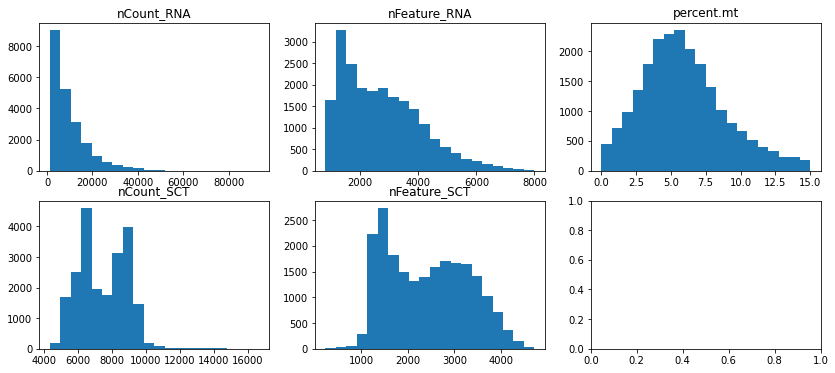

In [16]:
qc_obs = ["nCount_RNA", "nFeature_RNA", "percent.mt", "nCount_SCT", "nFeature_SCT"]
# plt.figure(); p = plt.hist(adata_obs[i], bins=20); plt.title(i)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))
i = 0
for j in range(2):
    for k in range(3):
        if (len(qc_obs)-1) >= i:
            axs[j, k].hist(adata_obs[qc_obs[i]], bins=20); axs[j, k].set_title(qc_obs[i]); i+=1

### 5. Remove doublets [if the info present] <a class="anchor" id="bullet5"></a>

### 6. Make object lightweight <a class="anchor" id="bullet6"></a>

Remove uns, varm, obsm, layers, and reduce obs columns if duplicated stuff or unlabelled clustering outputs exist.

In [17]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp
adata

AnnData object with n_obs × n_vars = 21700 × 31915
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'publication_ID', 'repository_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'disease_lung_known', 'subject_type', 'cause_of_death', 'anatomical_region_level1', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'study', 'dataset', 'sample', 'disease_condition', 'original_celltype_ann'

### 7. Check if you need to split them into datasets <a class="anchor" id="bullet7"></a>

If different protocols were used, e.g., 10X versions, or if there were single-nuclei data or cryopreserved samples.

#### 8. Write down everything you did in the "preprocessing" column <a class="anchor" id="bullet8"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0&range=Q1).

### 9. Subset to HVGs <a class="anchor" id="bullet9"></a>

Pad with 0s if needed.

In [18]:
adata.var

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC023491.2
AC233755.2
AC233755.1
AC240274.1


In [19]:
gene_set = pd.read_csv(genes_set_inp)
gene_set

,Unnamed: 0,gene_symbols
0,ENSG00000000938,FGR
1,ENSG00000000971,CFH
2,ENSG00000002587,HS3ST1
3,ENSG00000002933,TMEM176A
4,ENSG00000003436,TFPI
...,...,...
1995,ENSG00000280721,AC133644.2
1996,ENSG00000281103,TRG-AS1
1997,ENSG00000282122,CH17-262H11.1
1998,ENSG00000282988,RP1-34B20.21


In [20]:
adata_sub = pp.subset_and_pad_adata(gene_set, adata)

not all genes were recovered, filling in 0 counts for 102 missing genes...


In [21]:
adata_sub.var

,gene_symbols,ensembl
FGR,NaN,ENSG00000000938
CFH,NaN,ENSG00000000971
HS3ST1,NaN,ENSG00000002587
TMEM176A,NaN,ENSG00000002933
TFPI,NaN,ENSG00000003436
...,...,...
RP4-539M6.22,RP4-539M6.22,ENSG00000273428
RNU12,RNU12,ENSG00000270022
RP11-338I21.1,RP11-338I21.1,ENSG00000271933
AL928768.3,AL928768.3,ENSG00000253701


In [22]:
vars_keep = ["gene_symbols", "ensembl"]
for i in list(set(adata_sub.var.columns) - set(vars_keep)):
    del adata_sub.var[i]

In [23]:
adata_sub

AnnData object with n_obs × n_vars = 21700 × 2000
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'library_ID', 'publication_ID', 'repository_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'disease_lung_known', 'subject_type', 'cause_of_death', 'anatomical_region_level1', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'sequencing_platform', 'reference_genome', 'reference_genome_ensembl_release', 'reads_processing', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'study', 'dataset', 'sample', 'disease_condition', 'original_celltype_ann'
    var: 'gene_symbols', 'ensembl'

### 10. Store the data <a class="anchor" id="bullet10"></a>

In [24]:
adata_sub.write(adata_dir_out+'/full/tata_unpubl.h5ad')
adata_sub.write(adata_dir_out+'/subsetted/tata_unpubl.h5ad')

... storing 'institute' as categorical
... storing 'study_PI' as categorical
... storing 'sample_ID' as categorical
... storing 'subject_ID' as categorical
... storing 'library_ID' as categorical
... storing 'publication_ID' as categorical
... storing 'repository_ID' as categorical
... storing 'subject_ID_published' as categorical
... storing 'subject_developmental_state' as categorical
... storing 'sex' as categorical
... storing 'ethnicity_1' as categorical
... storing 'smoking_status' as categorical
... storing 'disease_lung_known' as categorical
... storing 'subject_type' as categorical
... storing 'cause_of_death' as categorical
... storing 'anatomical_region_level1' as categorical
... storing 'biological_unit' as categorical
... storing 'library_platform' as categorical
... storing 'strand_sequence' as categorical
... storing 'cell_enrichment' as categorical
... storing 'library_construction_batch' as categorical
... storing 'sequencing_platform' as categorical
... storing 'refer

#### 11. Update the stats for your dataset <a class="anchor" id="bullet11"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0)